In [64]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [65]:
def f(x):
  return 3*x**2 - 4*x + 5

In [66]:
f(3.0)

20.0

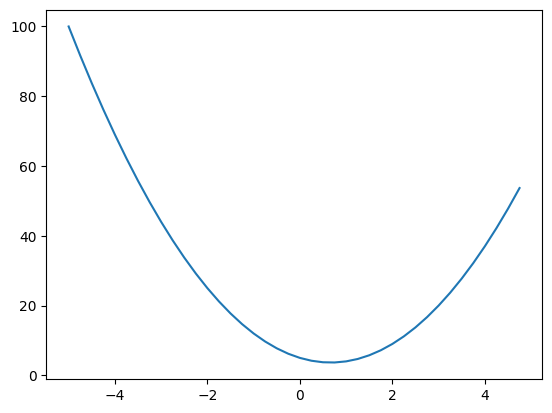

In [67]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [68]:
# definition of derivative
# ((f(x + h) - f(x)) / h)

h = 0.00000001
x = 2/3
print(f(x))
print(f(x + h))
print((f(x + h) - f(x)) / h) # numerical approximation of slope @ x

3.666666666666667
3.666666666666667
0.0


In [69]:
# finding derivative of d

h = 0.000000001

# inputs
a = 2.0
b = -3.0
c = 10.0

# d = 4.0
d1 = a * b + c
a += h
d2 = a * b + c

print('d1:', d1)
print('d2:', d2)
print('slope:', (d2 - d1)/h)

# slope is negative because a * b and b is negative. increasing a creates a smaller number.
# slope = -3

d1: 4.0
d2: 3.9999999969999998
slope: -3.000000248221113


In [84]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self): # repr = representation
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    return out
  
  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out
  
  def tanh(self):
    x = self.data
    t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
    out = Value(t, (self, ), 'tanh')
    return out

In [71]:
a = Value(2.0)
b = Value(-3.0)

print(a, b)
print(a + b) # a.__add__(b)
print(a * b) # a.__mul__(b)

Value(data=2.0) Value(data=-3.0)
Value(data=-1.0)
Value(data=-6.0)


In [72]:
# graphic representation to visualize expressions

from graphviz import Digraph

def trace(root):
  # builds set of all nodes and edges in graph
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any val in graph, create rectangular ('record') node for it
    dot.node(name = uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if n is result of some operation, create op node for it
      dot.node(name = uid + n._op, label = n._op)
      # connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [73]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
# (a.__mul__(b)).__add__(c)

f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

print(L)
print(L._prev)
print(L._op)

Value(data=-8.0)
{Value(data=-2.0), Value(data=4.0)}
*


In [74]:
L.grad = 1.0

# L = d * f
# dL/dd = f

# Let's derive 

# (f(x+h)*f - d*f)/h

# ((d+h)*f - d*f)/h
# (d*f + h*f - d*f)/h
# (h*f)/h
# f

f.grad = 4.0
d.grad = -2.0

In [75]:
# VERY IMPORTANT

# derivative two layers apart
# c -> d, d -> L

# dd / dc = 1.0
# dd / de = 1.0

# dd / dc ?
# d = c + e
# (f(x + h) - f(x)) / h
# ((c + h + e) - (c + e)) / h
# (c + h + e - c - e) / h
# h / h
# 1.0

# Derivative of sum (+) always = 1.0

# How to derive across two layers? Chain rule
# if a variable z depends on variable y and variable y depends on variable x,
# then variable z depends on variable x through the intermediate variable y

# Knowing instantaneous rate of change of z with respect to y and that of y relative to x
# allows you to calculate the instantaneous rate of change of z relative to x
# as the product of the two rates of change

# If car travels twice as fast as bike, and bike is 4 times as fast as walking,
# car travels 2x4 = 8 times as fast as walking

# dz/dx = dz/dy * dy/dx
# h'(x) = f'(g(x))g'(x)

# EXAMPLE

# WANT
# dL / dc

# KNOW
# dL / dd
# dd / dc

# CALCULATED
# dL / dc = (dL / dd) * (dd / dc)
# dL / dc = dL / dd

# (+) operation routes gradient backward since derivative = 1.0

c.grad = -2.0
e.grad = -2.0

In [76]:
# dL / de = -2.0

# 3 layers deep

# e = a * b
# de / da = b

# dL / da = (dL / de) * (de / da)
# Derivative of (*) product node = parent gradient * local gradient

a.grad = (-2.0 * -3.0) # 6
b.grad = (-2.0 * 2.0) # -4

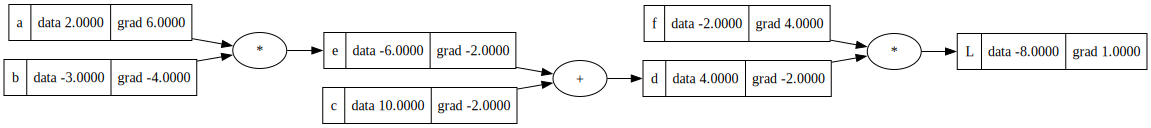

In [77]:
draw_dot(L)

In [78]:
# nudge leaf nodes towards gradient to increase L data

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


In [79]:
def lol():

  # INSTRUCTIONS
  # + h to any value in L2 that you would like to see the derivative of
  # ex. Value(2.0 + h)
  
  h = 0.0001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0 + h, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1) / h)

lol()

-1.9999999999953388


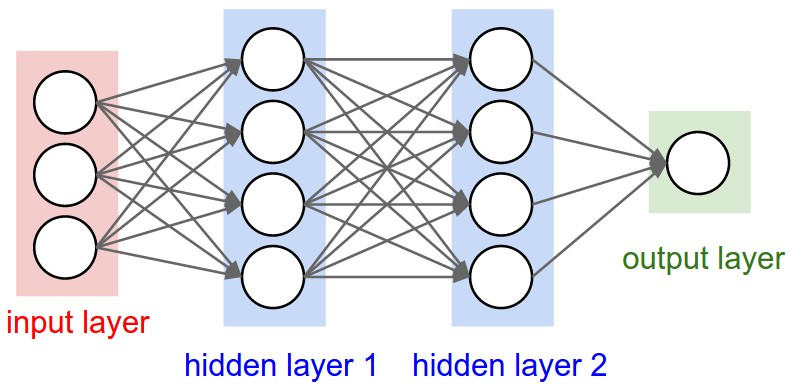

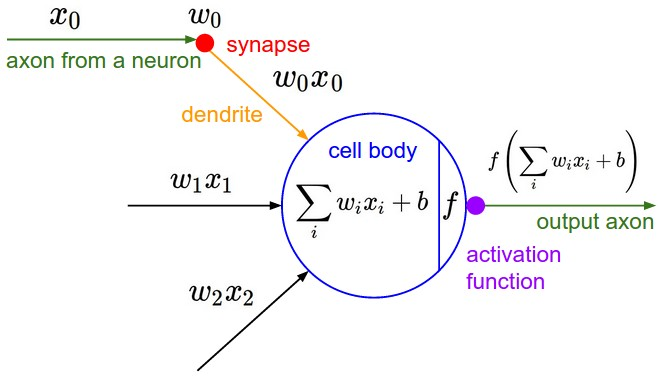

In [80]:
# synapse (weight w) interacts with input from neuron (x) = w * x
# cell body of neuron also has bias (b), makes cell more or less trigger happy
# sum of all w*x + bias is passed through activation function f
# activation function is typically a squashing function (like tanh)

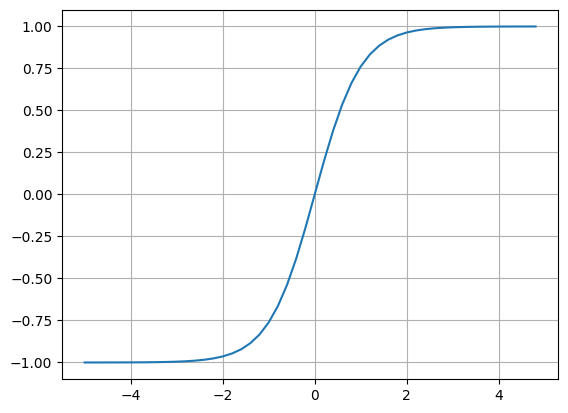

In [81]:
# tanh activation function example
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

In [93]:
# inputs x1 x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1 w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'

# squashing function
o = n.tanh(); o.label='o'
o.grad = 1.0

In [ ]:
# o = tanh(n)
# do / dn = 1 - tanh(n)**2
print(1 - o.data ** 2)
n.grad = 0.5

0.4999999999999999


In [ ]:
# grad passes down through (+) operation
x1w1x2w2.grad = 0.5
b.grad = 0.5

x1w1.grad = 0.5
x2w2.grad = 0.5

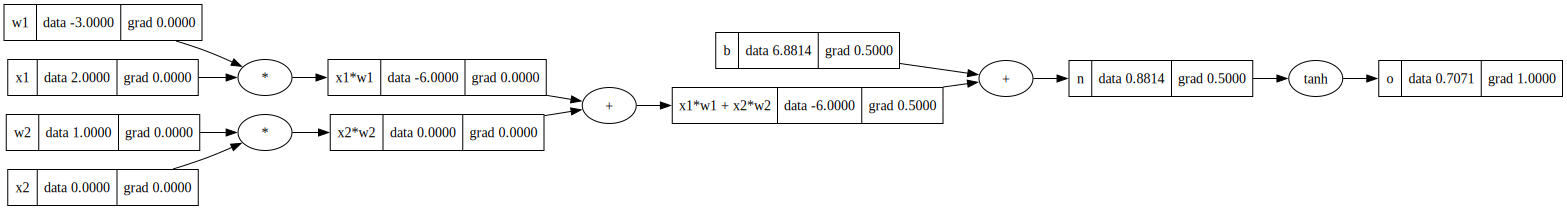

In [99]:
draw_dot(o)